In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

[INFO] Copying dataset 'mahmudulhaqueshawon/cat-image' to data/raw_data...
[INFO] Dataset ready at data/raw_data
[INFO] Getting clean[idx]: (tensor([[[ 0.0118, -0.0118, -0.0039,  ..., -0.1529, -0.1294, -0.0902],
         [ 0.0118, -0.0039,  0.0353,  ..., -0.2078, -0.1686, -0.0980],
         [ 0.0902, -0.0980, -0.2000,  ..., -0.2549, -0.1843, -0.0824],
         ...,
         [ 0.7490,  0.7569,  0.7490,  ..., -0.6314, -0.6706, -0.6627],
         [ 0.7412,  0.7490,  0.7333,  ..., -0.6314, -0.6471, -0.6549],
         [ 0.7490,  0.7569,  0.7333,  ..., -0.5137, -0.6000, -0.6549]],

        [[-0.3176, -0.3412, -0.3569,  ..., -0.4667, -0.4824, -0.4353],
         [-0.3255, -0.3412, -0.3098,  ..., -0.5216, -0.5216, -0.4431],
         [-0.2549, -0.4431, -0.5529,  ..., -0.5765, -0.5373, -0.4431],
         ...,
         [ 0.4510,  0.4588,  0.4510,  ..., -0.8196, -0.8745, -0.8510],
         [ 0.4510,  0.4588,  0.4431,  ..., -0.8196, -0.8510, -0.8588],
         [ 0.4588,  0.4667,  0.4431,  ..., -0.71

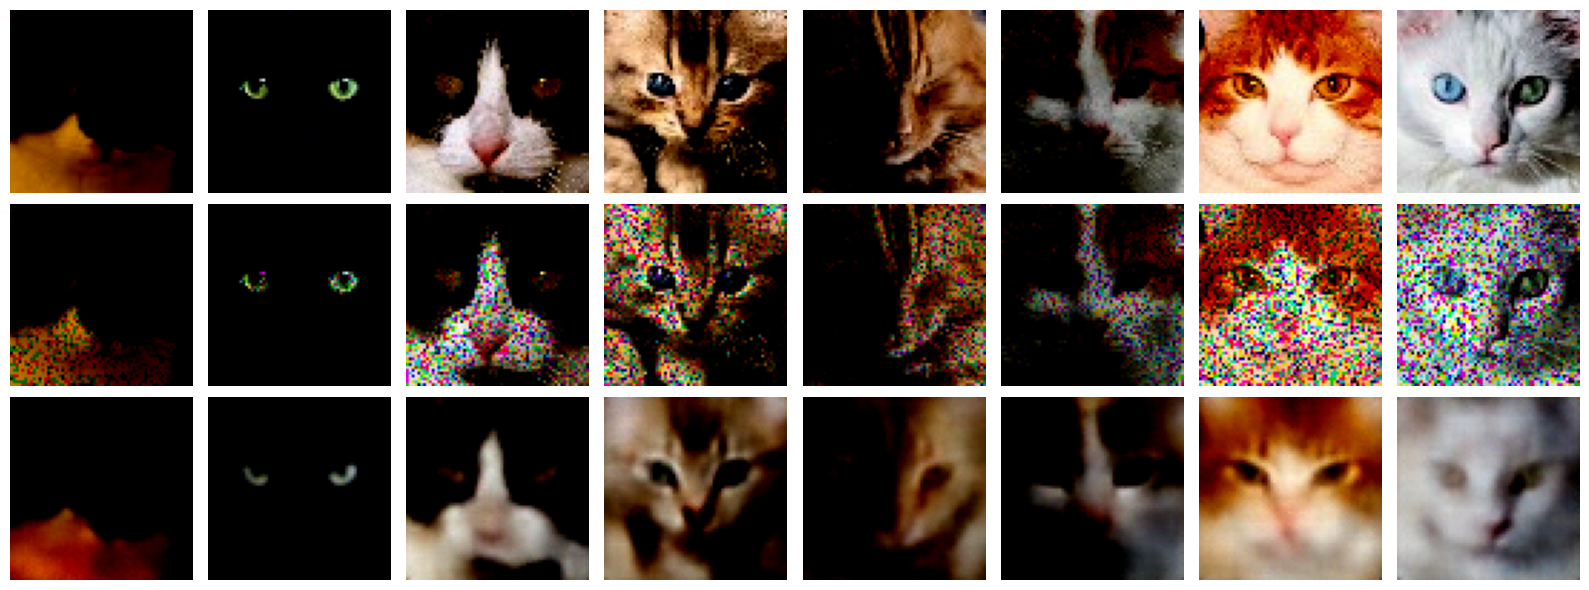

In [4]:
import torch
from src.scripts.etl_process.ETLProcessor import ETLProcessor
from src.scripts.training.MaskDataset import MaskedDataset
from src.models.vae.vae import VAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    latent_dim=256,
)
model.load_state_dict(
    torch.load("../models/test_run/test_vae_event0.pt", map_location=device)
)
model = model.to(device)
model.eval()

etl = ETLProcessor(
    kaggle_dataset="mahmudulhaqueshawon/cat-image",
    raw_dir="data/raw_data",
    split_dir="data/data_splits",
)
train_loader, val_loader, test_loader = etl.process()

mask_size = 0.3
mask_dataset = MaskedDataset(test_loader.dataset, mask_size)
mask_loader = torch.utils.data.DataLoader(
    mask_dataset, batch_size=8, shuffle=True, num_workers=0
)


mask_img, clean_img = next(iter(mask_loader))
mask_imgs = mask_img.to(device)
original_imgs = clean_img.to(device)

with torch.no_grad():
    reconstructed = model(mask_imgs)

reconstructed = reconstructed["recon"]


def show_images(original, noisy, reconstructed, n=8):
    import numpy as np
    import matplotlib.pyplot as plt

    n = min(n, original.size(0), noisy.size(0), reconstructed.size(0))

    fig, axes = plt.subplots(3, n, figsize=(n * 2, 6))

    if isinstance(axes, np.ndarray) and axes.ndim == 1:
        axes = axes.reshape(3, -1)

    for i in range(n):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[0, i].axis("off")

        axes[1, i].imshow(noisy[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[1, i].axis("off")

        axes[2, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[2, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Noisy", fontsize=12)
    axes[2, 0].set_ylabel("Reconstructed", fontsize=12)

    plt.tight_layout()
    plt.show()


show_images(original_imgs, mask_imgs, reconstructed, n=8)